# Gaussian Mixture Model with ADVI

Here, we describe how to use ADVI for inference of Gaussian mixture model. First, we will show that inference with ADVI does not need to modify the stochastic model, just call a function. Then, we will show how to use mini-batch, which is useful for large dataset. In this case, where the model should be slightly changed. 

First, create artificial data from a mixuture of two Gaussian components.  

In [1]:
%env THEANO_FLAGS=device=cpu,floatX=float32

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pymc3 as pm
import seaborn as sns
import theano.tensor as tt

from pymc3 import (
    NUTS,
    DensityDist,
    Dirichlet,
    Metropolis,
    MvNormal,
    Normal,
    Slice,
    find_MAP,
    sample,
)
from pymc3.math import logsumexp
from theano.tensor.nlinalg import det

print(f"Running on PyMC3 v{pm.__version__}")

env: THEANO_FLAGS=device=cpu,floatX=float32
Running on PyMC3 v3.11.2


In [2]:
%config InlineBackend.figure_format = 'retina'
RANDOM_SEED = 8927
rng = np.random.default_rng(RANDOM_SEED)
az.style.use("arviz-darkgrid")

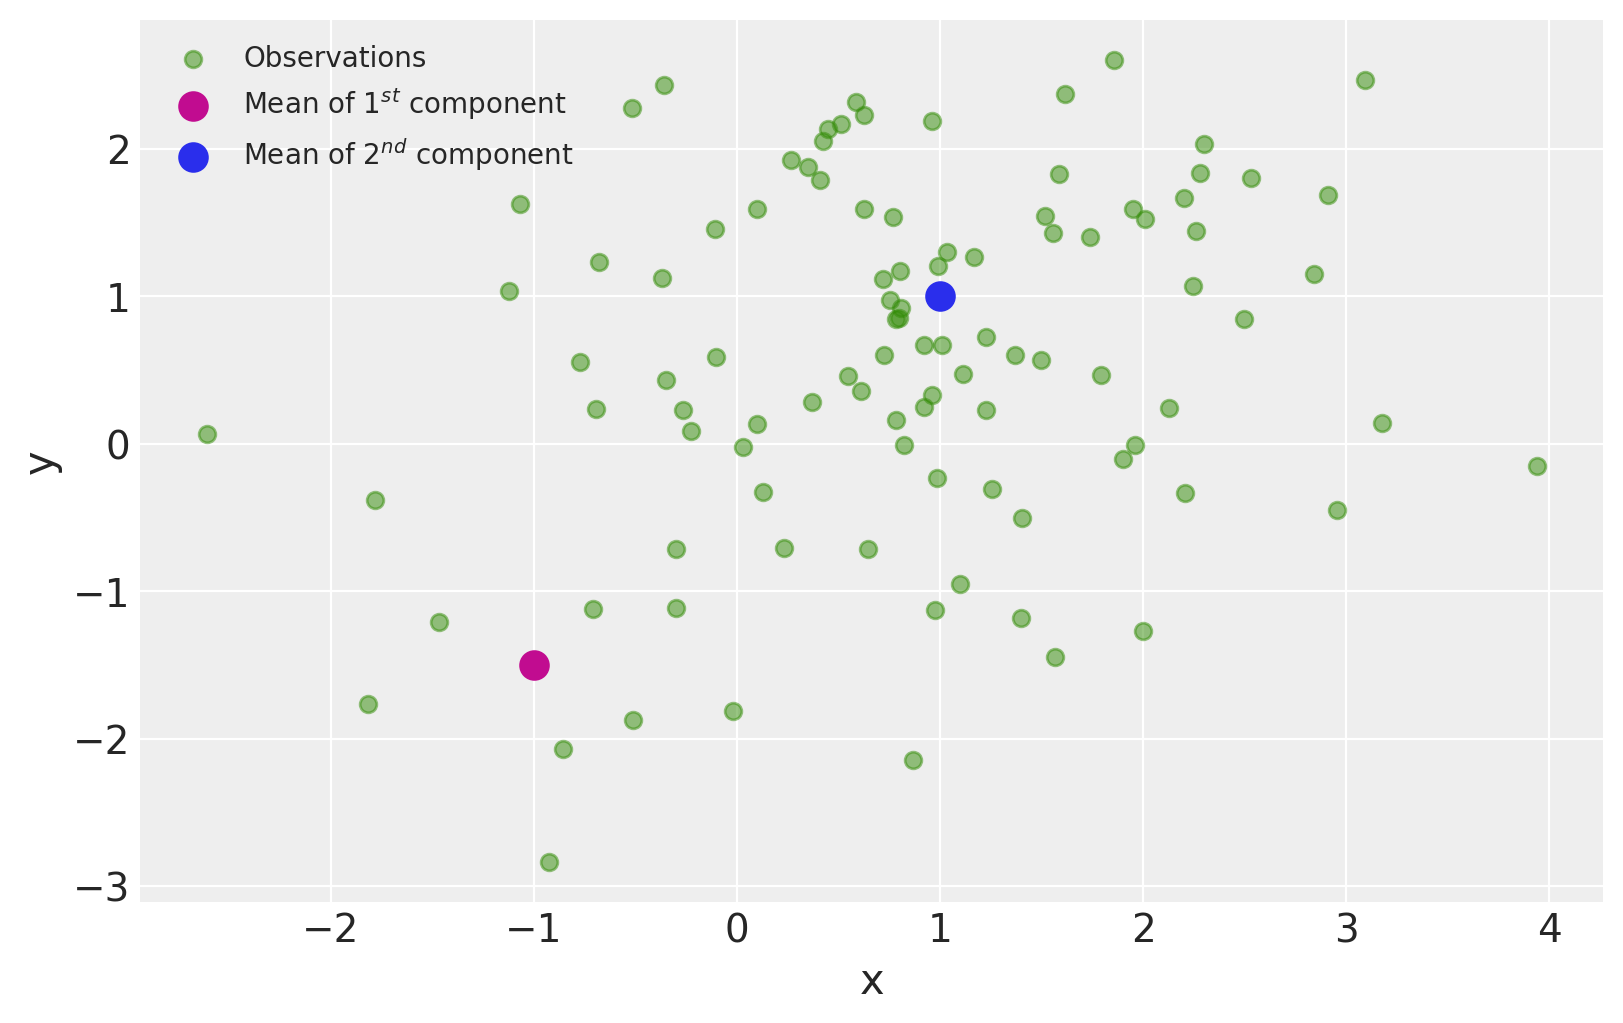

In [3]:
n_samples = 100
ms = np.array([[-1, -1.5], [1, 1]])
ps = np.array([0.2, 0.8])

zs = np.array([rng.multinomial(1, ps) for _ in range(n_samples)]).T
xs = [
    z[:, np.newaxis] * rng.multivariate_normal(m, np.eye(2), size=n_samples) for z, m in zip(zs, ms)
]
data = np.sum(np.dstack(xs), axis=2)

plt.figure(figsize=(8, 5))
plt.scatter(data[:, 0], data[:, 1], c="C2", alpha=0.5, label="Observations")
plt.scatter(ms[0, 0], ms[0, 1], c="C3", s=100, label="Mean of $1^{st}$ component")
plt.scatter(ms[1, 0], ms[1, 1], c="C0", s=100, label="Mean of $2^{nd}$ component")
plt.xlabel("x")
plt.ylabel("y")
plt.legend(loc="upper left", prop={"size": 10});

Gaussian mixture models are usually constructed with categorical random variables. However, any discrete random variables do not fit ADVI. Here, class assignment variables are marginalized out, giving weighted sum of the probability for the gaussian components. The log likelihood of the total probability is calculated using logsumexp, which is a standard technique for making this kind of calculation stable. 

In the below code, DensityDist class is used as the likelihood term. The second argument, `logp_gmix(mus, pi, np.eye(2))`, is a python function which recieves observations (denoted by 'value') and returns the tensor representation of the log-likelihood. 

In [4]:
# Log likelihood of normal distribution
def logp_normal(mu, tau, value):
    # log probability of individual samples
    k = tau.shape[0]
    delta = lambda mu: value - mu
    return (-1 / 2.0) * (
        k * tt.log(2 * np.pi)
        + tt.log(1.0 / det(tau))
        + (delta(mu).dot(tau) * delta(mu)).sum(axis=1)
    )


# Log likelihood of Gaussian mixture distribution
def logp_gmix(mus, pi, tau):
    def logp_(value):
        logps = [tt.log(pi[i]) + logp_normal(mu, tau, value) for i, mu in enumerate(mus)]

        return tt.sum(logsumexp(tt.stacklists(logps)[:, :n_samples], axis=0))

    return logp_

In [5]:
coords = {"component": [0, 1], "axis": ["x", "y"], "obs_id": np.arange(n_samples)}

with pm.Model(coords=coords) as model:
    mus = [
        MvNormal(
            "mu_%d" % i,
            mu=pm.floatX(np.zeros(2)),
            tau=pm.floatX(0.1 * np.eye(2)),
            dims="axis",
        )
        for i in range(2)
    ]
    pi = Dirichlet("pi", a=pm.floatX(0.1 * np.ones(2)), dims="component")
    xs = DensityDist("x", logp_gmix(mus, pi, np.eye(2)), observed=data, dims=("obs_id", "axis"))

For comparison with ADVI, run MCMC. 

In [6]:
with model:
    start = find_MAP()
    step = Metropolis()
    trace = sample(1000, step, start=start, return_inferencedata=True)

WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.
WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [pi]
>Metropolis: [mu_1]
>Metropolis: [mu_0]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


0, dim: obs_id, 1 =? 100


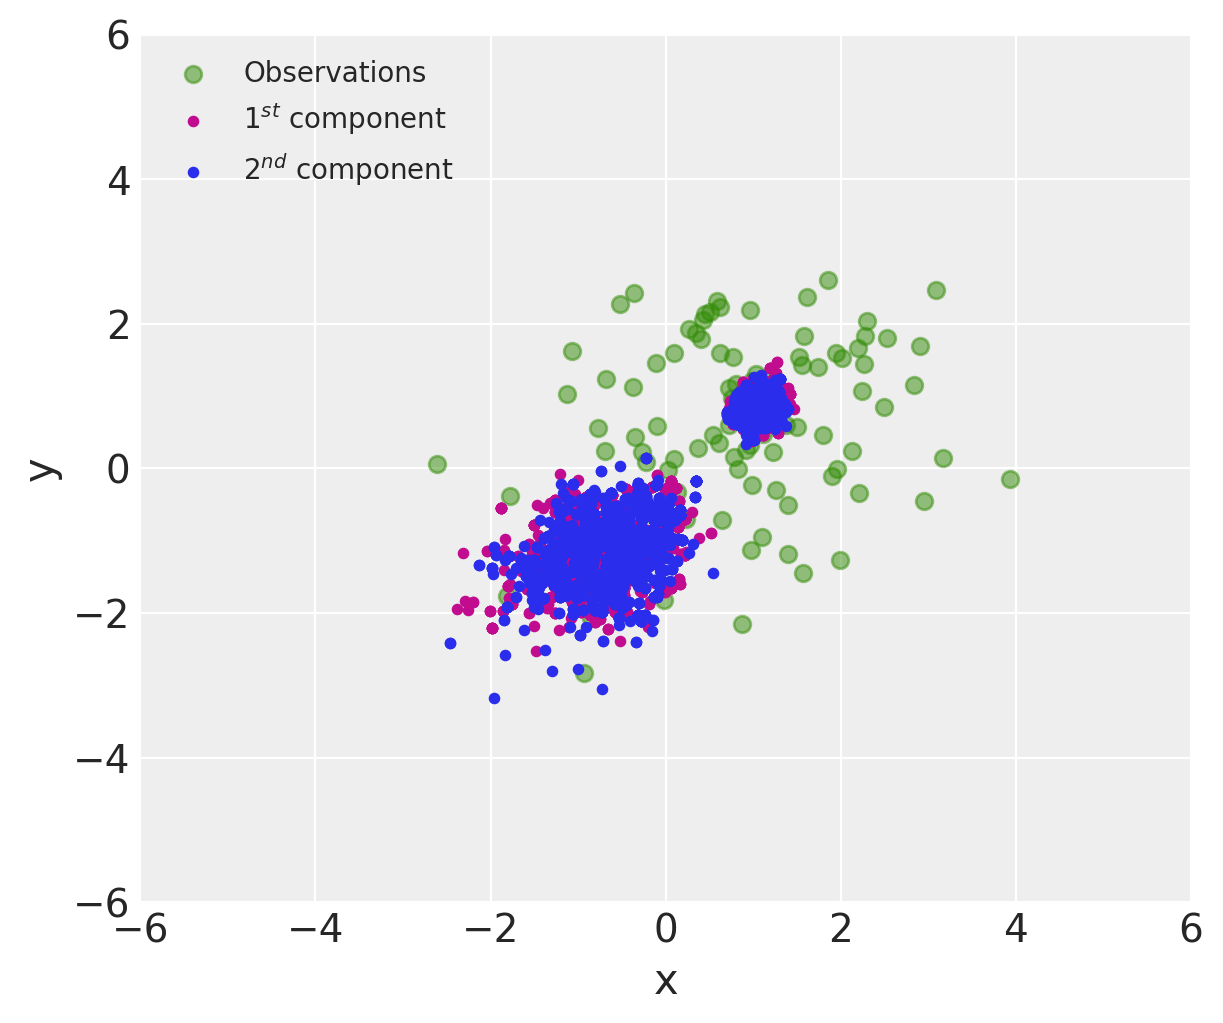

In [7]:
plt.figure(figsize=(6, 5))
plt.scatter(data[:, 0], data[:, 1], alpha=0.5, c="C2", label="Observations")
mu_0, mu_1 = trace.posterior["mu_0"], trace.posterior["mu_1"]
plt.scatter(mu_0.sel(axis="x"), mu_0.sel(axis="y"), c="C3", s=10, label="$1^{st}$ component")
plt.scatter(mu_1.sel(axis="x"), mu_1.sel(axis="y"), c="C0", s=10, label="$2^{nd}$ component")
plt.xlim(-6, 6)
plt.ylim(-6, 6)
plt.xlabel("x")
plt.ylabel("y")
plt.legend(loc="upper left", prop={"size": 10});

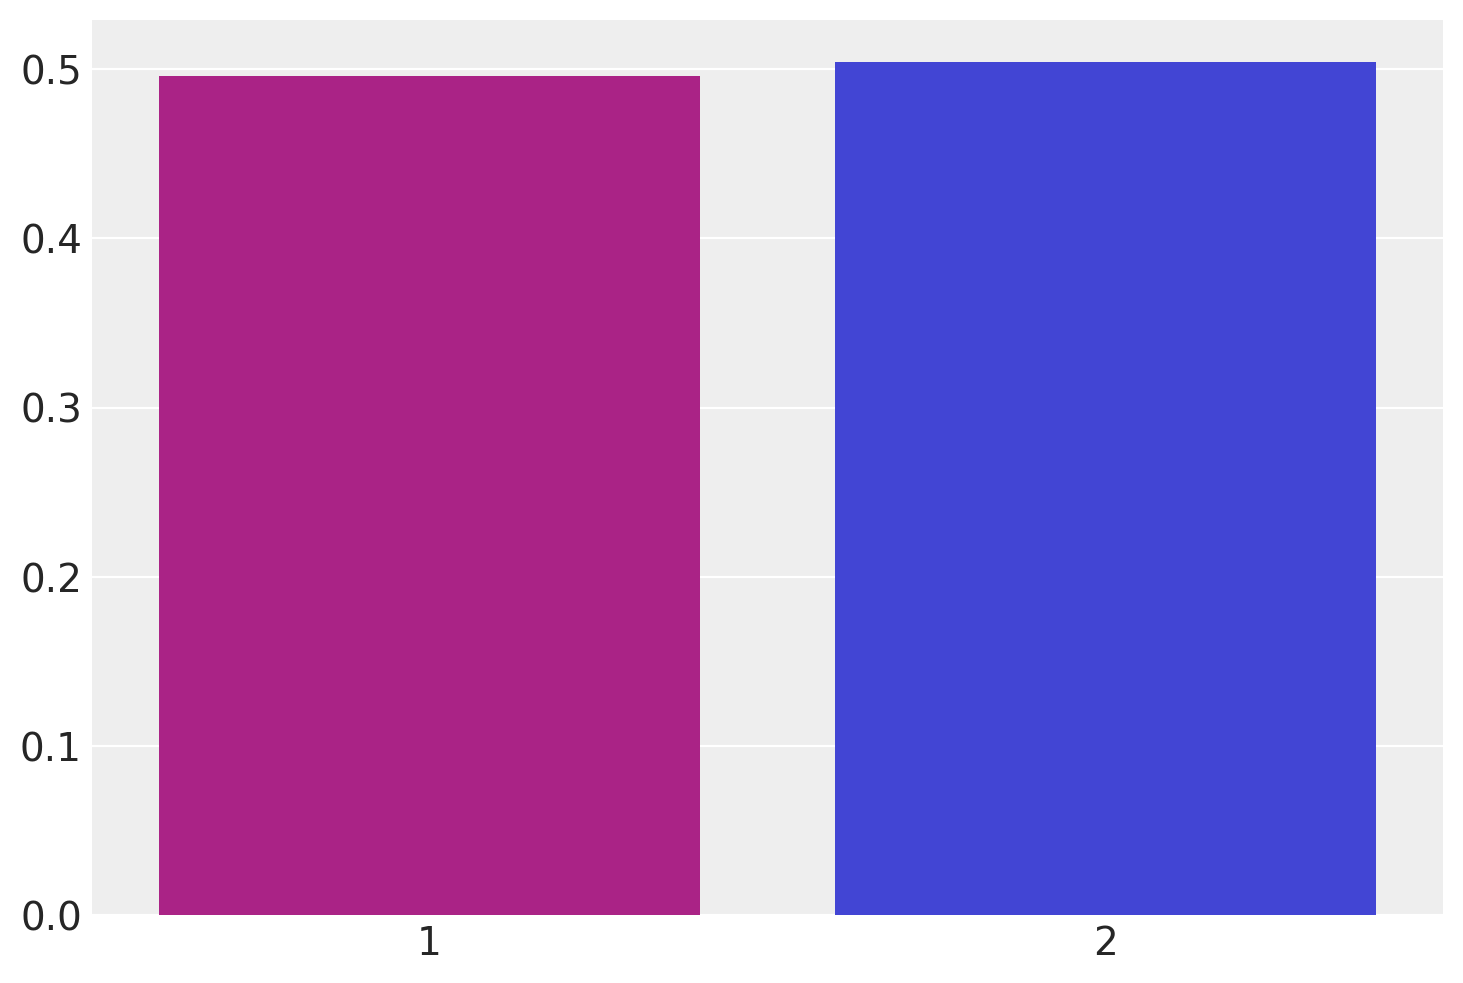

In [8]:
sns.barplot(
    x=[1, 2],
    y=np.mean(trace.posterior.stack(pooled_chain=("chain", "draw"))["pi"], axis=1),
    palette=["C3", "C0"],
);

We can use the same model with ADVI as follows. 

In [9]:
with pm.Model(coords=coords) as model:
    mus = [
        MvNormal(
            "mu_%d" % i,
            mu=pm.floatX(np.zeros(2)),
            tau=pm.floatX(0.1 * np.eye(2)),
            dims="axis",
        )
        for i in range(2)
    ]
    pi = Dirichlet("pi", a=pm.floatX(0.1 * np.ones(2)), dims="component")
    xs = DensityDist("x", logp_gmix(mus, pi, np.eye(2)), observed=data, dims=("obs_id", "axis"))

with model:
    %time approx = pm.fit(n=4500, obj_optimizer=pm.adagrad(learning_rate=1e-1))

means = approx.bij.rmap(approx.mean.eval())
cov = approx.cov.eval()
sds = approx.bij.rmap(np.diag(cov) ** 0.5)

/home/ada/.local/lib/python3.8/site-packages/theano/gpuarray/dnn.py:192: UserWarning: Your cuDNN version is more recent than Theano. If you encounter problems, try updating Theano or downgrading cuDNN to a version >= v5 and <= v7.
  warnings.warn(


Finished [100%]: Average Loss = 326.07


CPU times: user 2.75 s, sys: 201 ms, total: 2.95 s
Wall time: 6.63 s


The function returns three variables. 'means' and 'sds' are the mean and standart deviations of the variational posterior. Note that these values are in the transformed space, not in the original space. For random variables in the real line, e.g., means of the Gaussian components, no transformation is applied. Then we can see the variational posterior in the original space. 

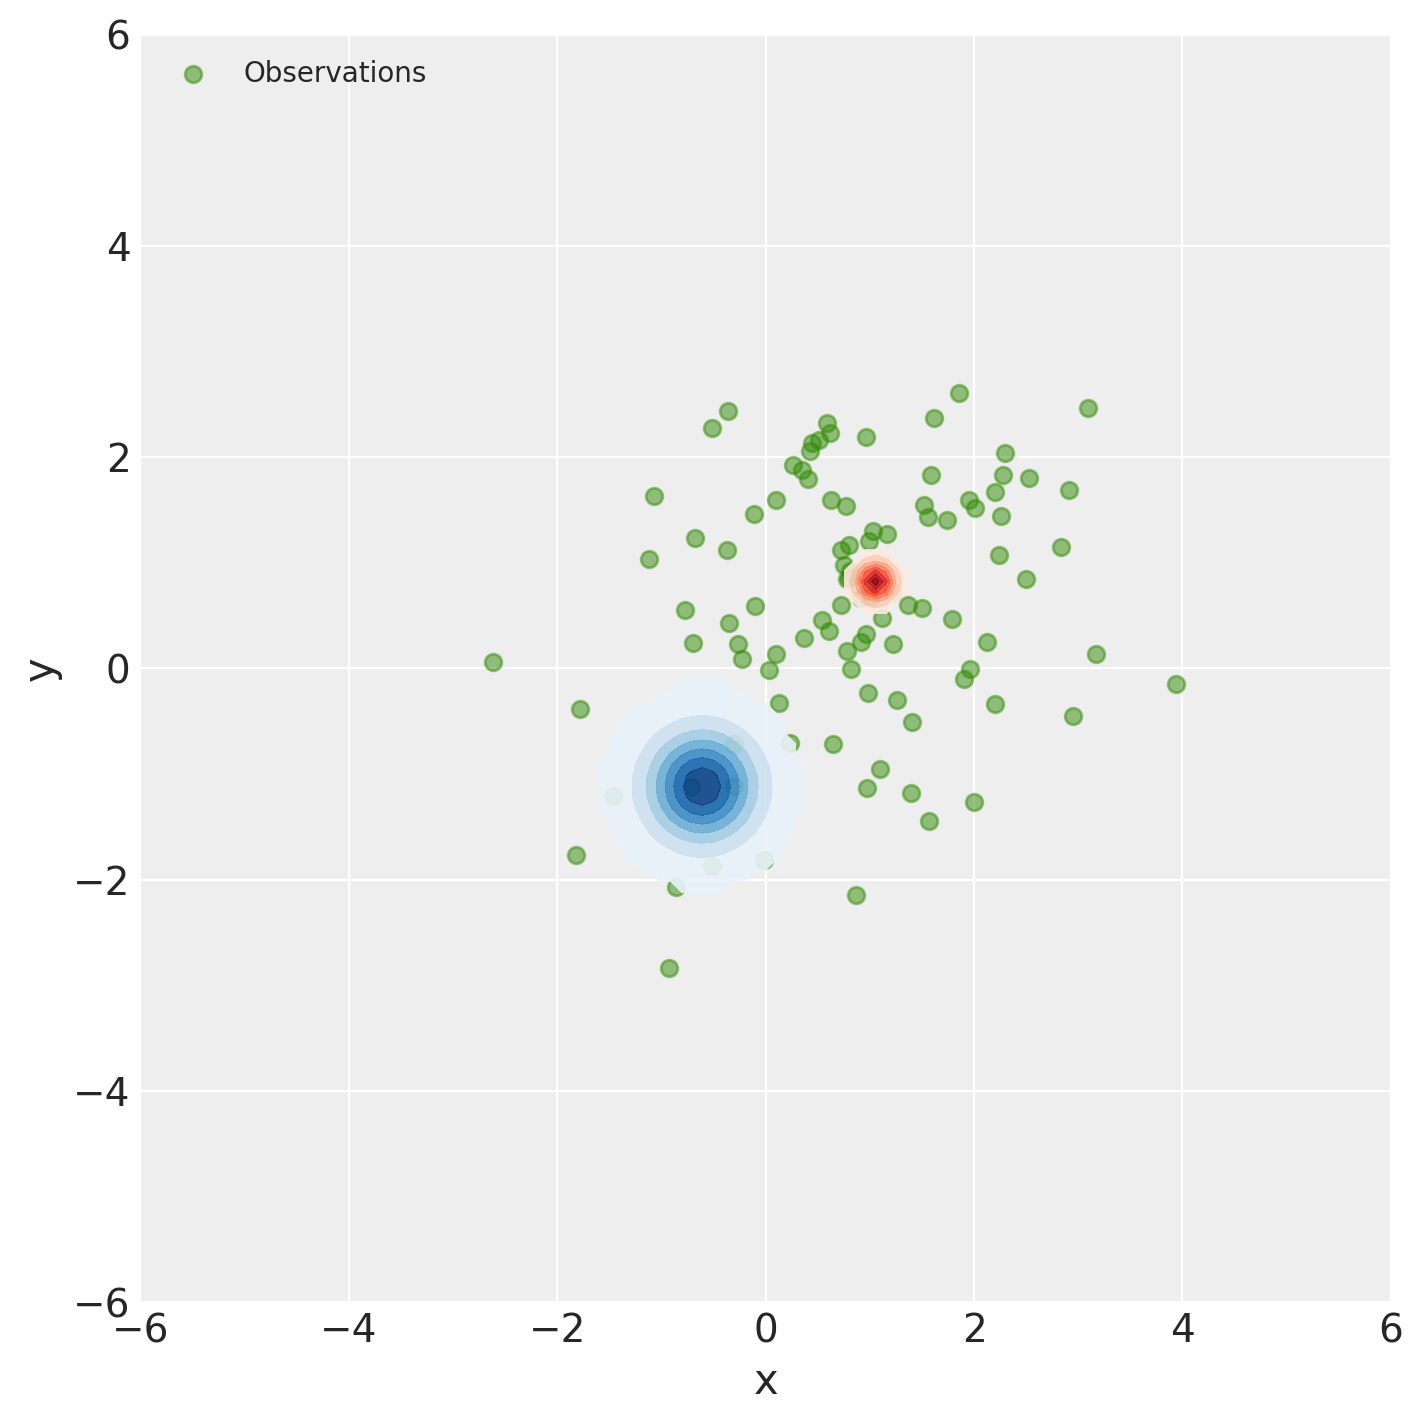

In [10]:
from copy import deepcopy

mu_0, sd_0 = means["mu_0"], sds["mu_0"]
mu_1, sd_1 = means["mu_1"], sds["mu_1"]


def logp_normal_np(mu, tau, value):
    # log probability of individual samples
    k = tau.shape[0]
    delta = lambda mu: value - mu
    return (-1 / 2.0) * (
        k * np.log(2 * np.pi)
        + np.log(1.0 / np.linalg.det(tau))
        + (delta(mu).dot(tau) * delta(mu)).sum(axis=1)
    )


def threshold(zz):
    zz_ = deepcopy(zz)
    zz_[zz < np.max(zz) * 1e-2] = None
    return zz_


def plot_logp_normal(ax, mu, sd, cmap):
    f = lambda value: np.exp(logp_normal_np(mu, np.diag(1 / sd ** 2), value))
    g = lambda mu, sd: np.arange(mu - 3, mu + 3, 0.1)
    xx, yy = np.meshgrid(g(mu[0], sd[0]), g(mu[1], sd[1]))
    zz = f(np.vstack((xx.reshape(-1), yy.reshape(-1))).T).reshape(xx.shape)
    ax.contourf(xx, yy, threshold(zz), cmap=cmap, alpha=0.9)


fig, ax = plt.subplots(figsize=(7, 7))
plt.scatter(data[:, 0], data[:, 1], alpha=0.5, c="C2", label="Observations")
plot_logp_normal(ax, mu_0, sd_0, cmap="Reds")
plot_logp_normal(ax, mu_1, sd_1, cmap="Blues")
plt.xlim(-6, 6)
plt.ylim(-6, 6)
plt.xlabel("x")
plt.ylabel("y")
plt.legend(loc="upper left", prop={"size": 10});

TODO: We need to backward-transform 'pi', which is transformed by 'stick_breaking'. 

'elbos' contains the trace of ELBO, showing stochastic convergence of the algorithm. 

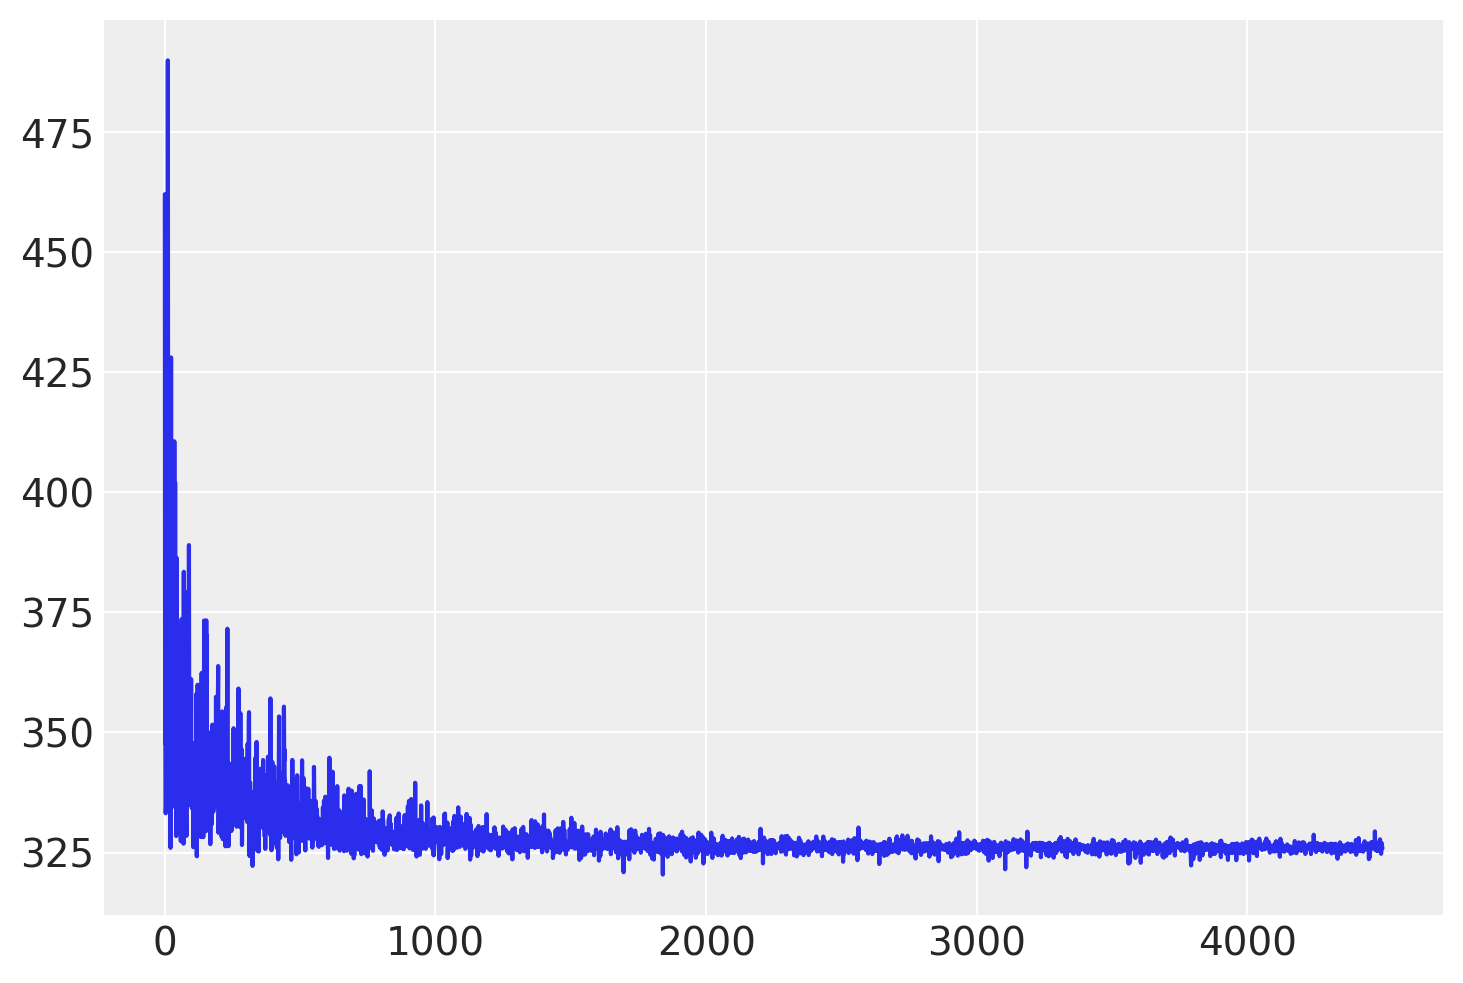

In [11]:
plt.plot(approx.hist);

To demonstrate that ADVI works for large dataset with mini-batch, let's create 100,000 samples from the same mixture distribution. 

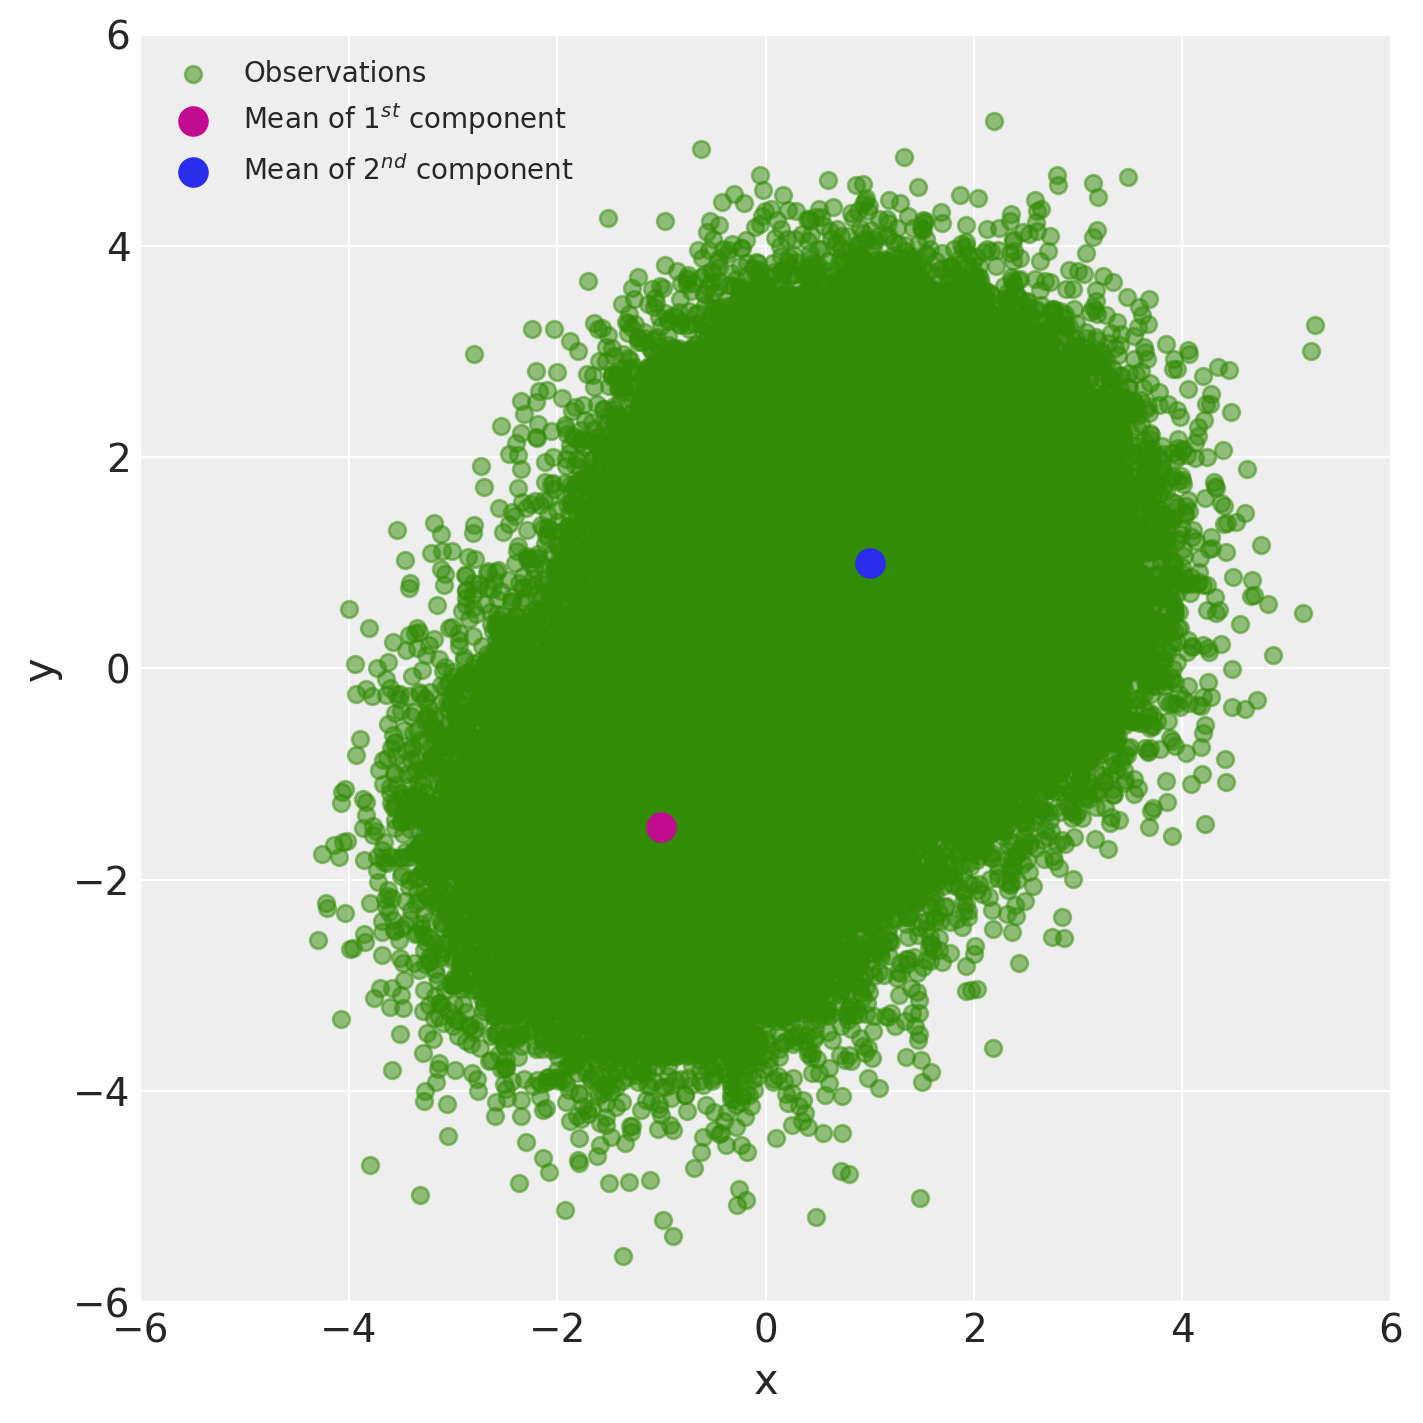

In [12]:
n_samples = 100000

zs = np.array([rng.multinomial(1, ps) for _ in range(n_samples)]).T
xs = [
    z[:, np.newaxis] * rng.multivariate_normal(m, np.eye(2), size=n_samples) for z, m in zip(zs, ms)
]
data = np.sum(np.dstack(xs), axis=2)

plt.figure(figsize=(7, 7))
plt.scatter(data[:, 0], data[:, 1], c="C2", alpha=0.5, label="Observations")
plt.scatter(ms[0, 0], ms[0, 1], c="C3", s=100, label="Mean of $1^{st}$ component")
plt.scatter(ms[1, 0], ms[1, 1], c="C0", s=100, label="Mean of $2^{nd}$ component")
plt.xlim(-6, 6)
plt.ylim(-6, 6)
plt.xlabel("x")
plt.ylabel("y")
plt.legend(loc="upper left", prop={"size": 10});

MCMC took 55 seconds, 20 times longer than the small dataset. 

In [13]:
coords["obs_id"] = np.arange(n_samples)

with pm.Model(coords=coords) as model:
    mus = [
        MvNormal(
            "mu_%d" % i,
            mu=pm.floatX(np.zeros(2)),
            tau=pm.floatX(0.1 * np.eye(2)),
            dims="axis",
        )
        for i in range(2)
    ]
    pi = Dirichlet("pi", a=pm.floatX(0.1 * np.ones(2)), dims="component")
    xs = DensityDist("x", logp_gmix(mus, pi, np.eye(2)), observed=data, dims=("obs_id", "axis"))

    start = find_MAP()
    step = Metropolis()
    trace = sample(1000, step, start=start, return_inferencedata=True)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [pi]
>Metropolis: [mu_1]
>Metropolis: [mu_0]


/home/ada/.local/lib/python3.8/site-packages/pymc3/step_methods/metropolis.py:226: RuntimeWarning: overflow encountered in exp
  "accept": np.exp(accept),
/home/ada/.local/lib/python3.8/site-packages/pymc3/step_methods/metropolis.py:226: RuntimeWarning: overflow encountered in exp
  "accept": np.exp(accept),
/home/ada/.local/lib/python3.8/site-packages/pymc3/step_methods/metropolis.py:226: RuntimeWarning: overflow encountered in exp
  "accept": np.exp(accept),
/home/ada/.local/lib/python3.8/site-packages/pymc3/step_methods/metropolis.py:226: RuntimeWarning: overflow encountered in exp
  "accept": np.exp(accept),
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1129 seconds.


0, dim: obs_id, 1 =? 100000


The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


Posterior samples are concentrated on the true means, so looks like single point for each component. 

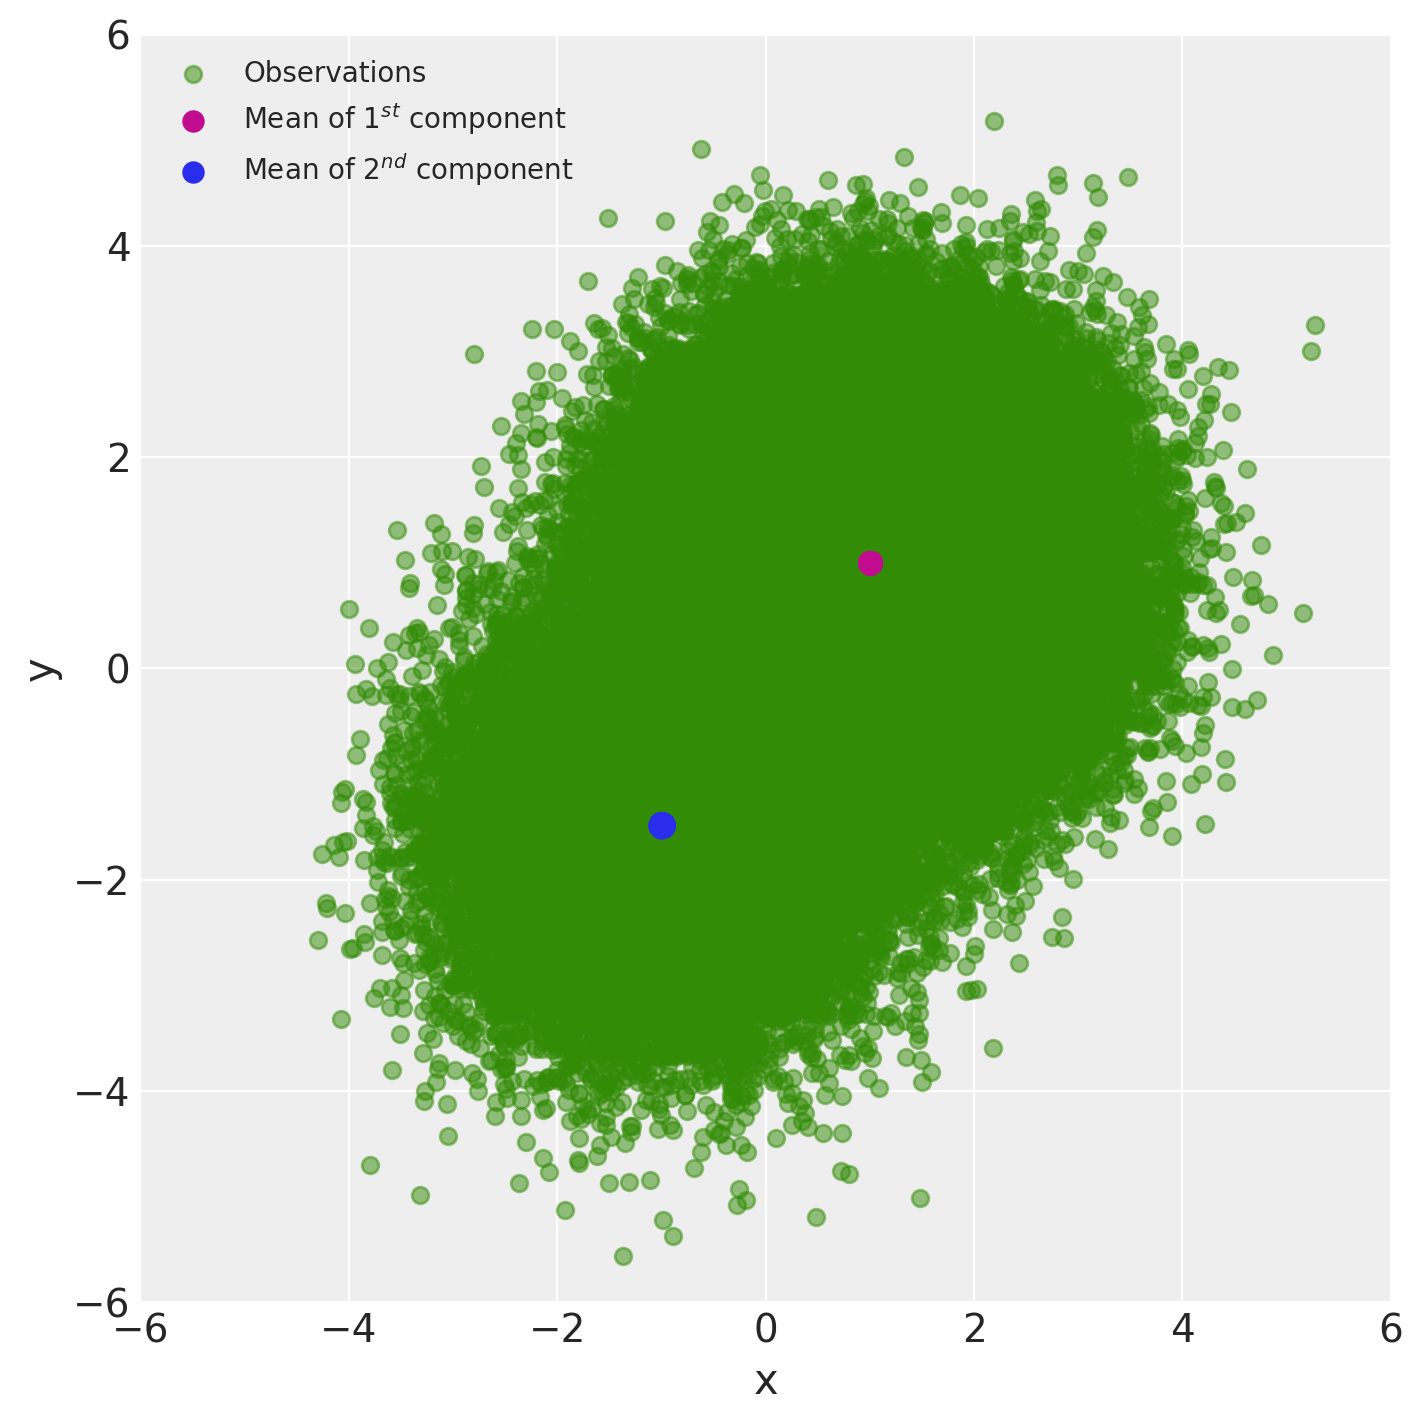

In [14]:
posterior = trace.posterior.stack(pooled_chain=("chain", "draw"))

plt.figure(figsize=(7, 7))
plt.scatter(data[:, 0], data[:, 1], alpha=0.5, c="C2", label="Observations")
mu_0, mu_1 = posterior["mu_0"].isel(pooled_chain=slice(3500, 4000)), posterior["mu_1"].isel(
    pooled_chain=slice(3500, 4000)
)
plt.scatter(
    mu_0.sel(axis="x"), mu_0.sel(axis="y"), c="C3", s=50, label="Mean of $1^{st}$ component"
)
plt.scatter(
    mu_1.sel(axis="x"), mu_1.sel(axis="y"), c="C0", s=50, label="Mean of $2^{nd}$ component"
)
plt.xlim(-6, 6)
plt.ylim(-6, 6)
plt.xlabel("x")
plt.ylabel("y")
plt.legend(loc="upper left", prop={"size": 10});

For ADVI with mini-batch, put theano tensor on the observed variable of the ObservedRV. The tensor will be replaced with mini-batches. Because of the difference of the size of mini-batch and whole samples, the log-likelihood term should be appropriately scaled. To tell the log-likelihood term, we need to give ObservedRV objects ('minibatch_RVs' below) where mini-batch is put. Also we should keep the tensor ('minibatch_tensors'). 

In [15]:
minibatch_size = 200
# In memory Minibatches for better speed
data_t = pm.Minibatch(data, minibatch_size)

with pm.Model(coords=coords) as model:
    mus = [
        MvNormal(
            "mu_%d" % i,
            mu=pm.floatX(np.zeros(2)),
            tau=pm.floatX(0.1 * np.eye(2)),
            dims="axis",
        )
        for i in range(2)
    ]
    pi = Dirichlet("pi", a=pm.floatX(0.1 * np.ones(2)), dims="component")
    xs = DensityDist(
        "x",
        logp_gmix(mus, pi, np.eye(2)),
        observed=data_t,
        total_size=len(data),
        dims=("obs_id", "axis"),
    )

/home/ada/.local/lib/python3.8/site-packages/pymc3/data.py:316: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  self.shared = theano.shared(data[in_memory_slc])


Run ADVI. It's much faster than MCMC, though the problem here is simple and it's not a fair comparison. 

In [16]:
# Used only to write the function call in single line for using %time
# is there more smart way?


def f():
    approx = pm.fit(n=1500, obj_optimizer=pm.adagrad(learning_rate=1e-1), model=model)
    means = approx.bij.rmap(approx.mean.eval())
    sds = approx.bij.rmap(approx.std.eval())
    return means, sds, approx.hist


%time means, sds, elbos = f()

Finished [100%]: Average Loss = 652.49


CPU times: user 3.35 s, sys: 92.5 ms, total: 3.45 s
Wall time: 5.09 s


The result is almost the same. 

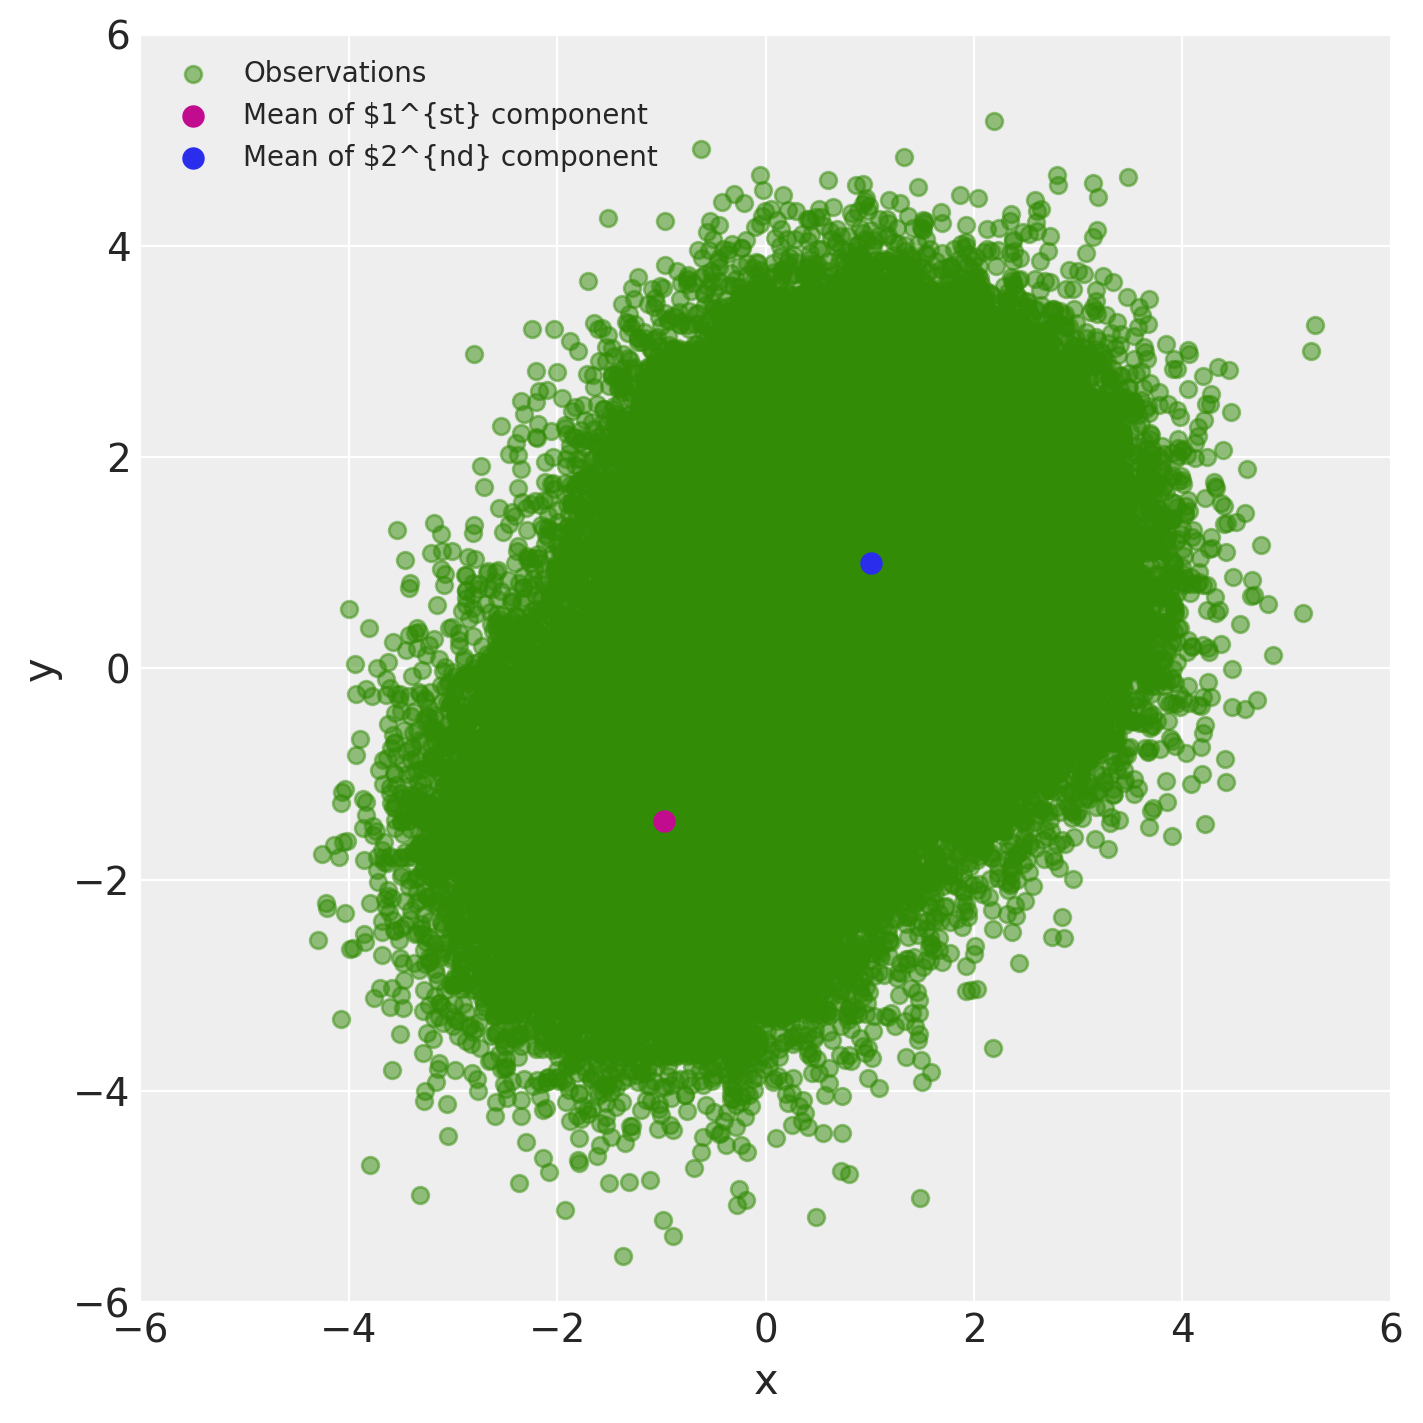

In [20]:
from copy import deepcopy

mu_0, sd_0 = means["mu_0"], sds["mu_0"]
mu_1, sd_1 = means["mu_1"], sds["mu_1"]

fig, ax = plt.subplots(figsize=(7, 7))
plt.scatter(data[:, 0], data[:, 1], alpha=0.5, c="C2", label="Observations")
plt.scatter(mu_0[0], mu_0[1], c="C3", s=50, label="Mean of $1^{st} component")
plt.scatter(mu_1[0], mu_1[1], c="C0", s=50, label="Mean of $2^{nd} component")
plt.xlim(-6, 6)
plt.ylim(-6, 6)
plt.xlabel("x")
plt.ylabel("y")
plt.legend(loc="upper left", prop={"size": 10});

The variance of the trace of ELBO is larger than without mini-batch because of the subsampling from the whole samples. 

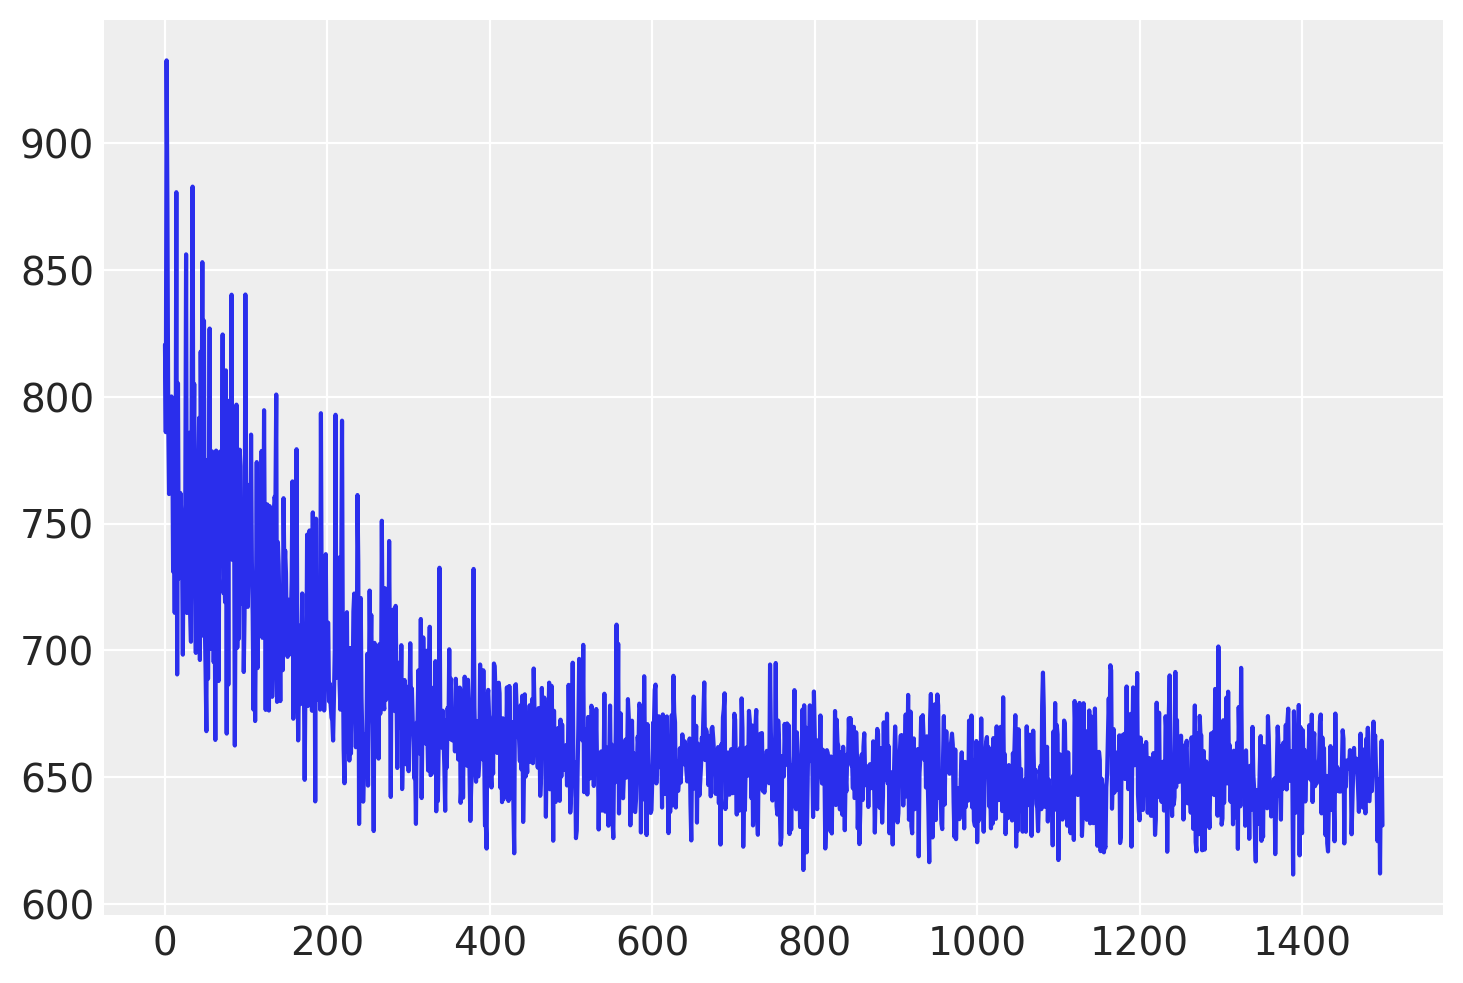

In [21]:
plt.plot(elbos);

In [22]:
%load_ext watermark
%watermark -n -u -v -iv -w -p xarray

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
Last updated: Tue Sep 14 2021

Python implementation: CPython
Python version       : 3.8.10
IPython version      : 7.25.0

xarray: 0.17.0

theano    : 1.1.2
numpy     : 1.21.0
matplotlib: 3.3.4
seaborn   : 0.11.1
arviz     : 0.11.2
pymc3     : 3.11.2

Watermark: 2.2.0

